# AM115 Mini Project: Tennis Modelling

## Data Collection and Preprocessing

In [ ]:
!git clone https://github.com/Jimmy-Mendez/AM115-Mini-Project-1.git

DATA_PATH = 'AM115-Mini-Project-1/'

fatal: destination path 'AM115-Mini-Project-1' already exists and is not an empty directory.


In [ ]:
import pandas as pd

with open(DATA_PATH+'match_scores_1877-1967_unindexed.csv', 'r') as fh:
    scores = pd.read_csv(fh)
with open(DATA_PATH+'match_scores_1968-1990_unindexed.csv', 'r') as fh:
    scores_2 = pd.read_csv(fh)
with open(DATA_PATH+'match_scores_1991-2016_unindexed.csv', 'r') as fh:
    scores_3 = pd.read_csv(fh)
with open(DATA_PATH+'tournaments_1877-2017_unindexed.csv', 'r') as fh:
    tourn = pd.read_csv(fh)

In [ ]:
scores = pd.concat([scores, scores_2], ignore_index=True)
scores = pd.concat([scores, scores_3], ignore_index=True)
print(scores.columns)
print(tourn.columns)
print([x for x in scores.columns if x in tourn.columns])

Index(['tourney_year_id', 'tourney_order', 'tourney_slug',
       'tourney_url_suffix', 'tourney_round_name', 'round_order',
       'match_order', 'winner_name', 'winner_player_id', 'winner_slug',
       'loser_name', 'loser_player_id', 'loser_slug', 'winner_seed',
       'loser_seed', 'match_score_tiebreaks', 'winner_sets_won',
       'loser_sets_won', 'winner_games_won', 'loser_games_won',
       'winner_tiebreaks_won', 'loser_tiebreaks_won', 'match_id',
       'match_stats_url_suffix'],
      dtype='object')
Index(['tourney_year', 'tourney_order', 'tourney_name', 'tourney_id',
       'tourney_slug', 'tourney_location', 'tourney_dates', 'tourney_month',
       'tourney_day', 'tourney_singles_draw', 'tourney_doubles_draw',
       'tourney_conditions', 'tourney_surface', 'tourney_fin_commit',
       'tourney_url_suffix', 'singles_winner_name', 'singles_winner_url',
       'singles_winner_player_slug', 'singles_winner_player_id',
       'doubles_winner_1_name', 'doubles_winner_1_url',
 

In [ ]:
new_data = scores.merge(tourn, on = ['tourney_year_id', 'tourney_order', 'tourney_slug', 'tourney_url_suffix'])
print(new_data.head())

  tourney_year_id  tourney_order tourney_slug  \
0        1877-540              1    wimbledon   
1        1877-540              1    wimbledon   
2        1877-540              1    wimbledon   
3        1877-540              1    wimbledon   
4        1877-540              1    wimbledon   

                              tourney_url_suffix tourney_round_name  \
0  /en/scores/archive/wimbledon/540/1877/results             Finals   
1  /en/scores/archive/wimbledon/540/1877/results        Semi-Finals   
2  /en/scores/archive/wimbledon/540/1877/results     Quarter-Finals   
3  /en/scores/archive/wimbledon/540/1877/results     Quarter-Finals   
4  /en/scores/archive/wimbledon/540/1877/results     Quarter-Finals   

   round_order  match_order       winner_name winner_player_id  \
0            1            1      Spencer Gore             gi91   
1            2            1      Spencer Gore             gi91   
2            3            1      Spencer Gore             gi91   
3            3

In [ ]:
print(new_data[['match_score_tiebreaks','winner_sets_won','loser_sets_won','winner_games_won','loser_games_won']])

       match_score_tiebreaks  winner_sets_won  loser_sets_won  \
0                   61 62 64                3               0   
1                   62 65 62                3               0   
2                63 62 56 61                3               1   
3                   63 63 65                3               0   
4                65 56 64 61                3               1   
...                      ...              ...             ...   
188379              63 16 64                2               1   
188380                 63 62                2               0   
188381                 62 63                2               0   
188382          67(10) 60 62                2               1   
188383                 63 64                2               0   

        winner_games_won  loser_games_won  
0                     18                7  
1                     18                9  
2                     23               12  
3                     18               11  

In [ ]:
print(new_data[['match_score_tiebreaks']])

       match_score_tiebreaks
0                   61 62 64
1                   62 65 62
2                63 62 56 61
3                   63 63 65
4                65 56 64 61
...                      ...
188379              63 16 64
188380                 63 62
188381                 62 63
188382          67(10) 60 62
188383                 63 64

[188384 rows x 1 columns]


## Tennis Game Modelling

### Data Simulation

In [ ]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

def simulate_tennis_game(p_win_point):
    points_won = 0
    points_lost = 0

    while True:
        if np.random.rand() < p_win_point:
            points_won += 1
        else:
            points_lost += 1

        # Check for win conditions before Deuce
        if points_won >= 4 and points_won - points_lost >= 2:
            return 1

        if points_lost >= 4 and points_lost - points_won >= 2:
            return 0

        # Handle Deuce scenario
        if points_won >= 3 and points_lost >= 3:
            while True:  # Continue until one player wins by 2 points
                if np.random.rand() < p_win_point:
                    points_won += 1
                else:
                    points_lost += 1

                if points_won - points_lost == 2:  # Win by 2 points
                    return 1
                if points_lost - points_won == 2:  # Win by 2 points
                    return 0


def simulate_games(n_games, p_win_point):
    p_g = []
    for _ in range(n_games):
        wins = simulate_tennis_game(p_win_point)
        p_g.append(wins)
    return sum(p_g)/len(p_g)

p_win_point = 0.55
n_games = 10000
prob_game = simulate_games(n_games, p_win_point)

print(prob_game)


0.6343


### Theoretical Model

In [ ]:
from math import comb

epsilon = 1e-10

def theoretical_probability(p):
    p_love = p**4
    p_15 = 4 * p**4 * (1-p)
    p_30 = 10 * p**4 * (1-p)**2
    p_deuce = (20 * p**5 * (1-p)**3) / (1 - (2*p*(1-p)))

    return p_love + p_15 + p_30 + p_deuce

### Model Plotting

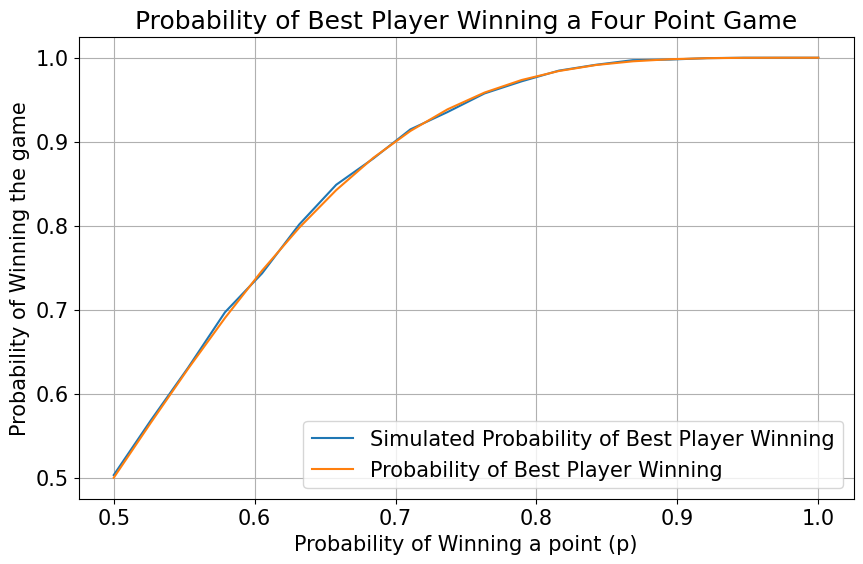

In [ ]:
p_values = np.linspace(.5, 1, 20)

simulated_probs = [simulate_games(10000, p) for p in p_values]

# Calculate the probability of the best player winning for each p value
probabilities = [theoretical_probability(p) for p in p_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(p_values, simulated_probs, label='Simulated Probability of Best Player Winning')
plt.plot(p_values, probabilities, label='Probability of Best Player Winning')
plt.title('Probability of Best Player Winning a Four Point Game')
plt.xlabel('Probability of Winning a point (p)')
plt.ylabel('Probability of Winning the game')
plt.grid(True)
plt.legend()
plt.show()



## Tennis 6 Game Sets Modelling

### Data Processing

In [ ]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
def count_loser_games(score_str):
    # Split the score string into individual set scores
    score_str = str(score_str)
    sets = score_str.split(' ')
    return sets

# Load data.  Each competition reports the number of sets the losing player wins.
# Filter data on best-of-five set matches only, i.e. match winner wins 3 sets.

data = new_data['match_score_tiebreaks']
five_set_max = new_data[new_data['winner_sets_won'] == 3]
filter = five_set_max['match_score_tiebreaks'].str.contains('\(')
five_set_max = five_set_max[~filter]


list_games = []
for index, row in five_set_max.iterrows():
  items = count_loser_games(row["match_score_tiebreaks"])
  for item in items:
    if item in ['60', '61', '62', '63', '64', '65', '75', '06', '16', '26', '36', '46', '56', '57']:
      list_games.append(item)


n = len(five_set_max)
print(n)

print(list_games)

list_games_loser = [x.replace('6','') for x in list_games]
list_games_loser = [x.replace('7','') for x in list_games_loser]

print(list_games_loser)

n0, n1, n2, n3, n4, n5 = np.bincount(list_games_loser)
print('Winner\tLoser\tFrequency')
print('-------------------------')
print(f'6\t0\t{n0}')
print(f'6\t1\t{n1}')
print(f'6\t2\t{n2}')
print(f'6\t3\t{n3}')
print(f'6\t4\t{n4}')
print(f'7\t5\t{n5}')
print('-------------------------')
print(f'Total:\t\t{n0+n1+n2+n3+n4+n5}')

37080
['61', '62', '64', '62', '65', '62', '63', '62', '56', '61', '63', '63', '65', '65', '56', '64', '61', '64', '46', '62', '61', '63', '46', '60', '65', '64', '62', '62', '46', '65', '61', '46', '63', '60', '60', '64', '61', '64', '60', '62', '65', '62', '62', '60', '63', '64', '62', '36', '62', '60', '62', '63', '61', '65', '65', '63', '65', '60', '36', '16', '62', '63', '63', '61', '61', '61', '75', '61', '64', '64', '64', '63', '61', '63', '64', '36', '61', '36', '65', '60', '64', '63', '61', '63', '56', '61', '62', '63', '60', '60', '62', '62', '65', '56', '65', '64', '64', '62', '46', '46', '65', '61', '61', '61', '62', '61', '61', '56', '64', '65', '63', '56', '64', '64', '65', '61', '06', '64', '16', '62', '56', '65', '36', '62', '61', '61', '26', '60', '60', '60', '60', '60', '62', '63', '63', '61', '61', '63', '63', '62', '60', '62', '61', '63', '56', '61', '61', '62', '61', '61', '63', '64', '62', '60', '56', '62', '26', '65', '65', '62', '62', '61', '65', '64', '60', '60

### NLL Mosteller Model

In [ ]:
import numpy as np

def NLL_Mosteller(p_g, outcomes):
    # Convert p_g to q_g
    q_g = 1 - p_g

    # Count the number of outcomes for each score
    counts = np.zeros(6)  # For scores: 6-0, 6-1, 6-2, 6-3, 6-4, and 7-5
    for outcome in outcomes:
        if outcome[0] == 6 and outcome[1] == 0:
            counts[0] += 1
        elif outcome[0] == 6 and outcome[1] == 1:
            counts[1] += 1
        elif outcome[0] == 6 and outcome[1] == 2:
            counts[2] += 1
        elif outcome[0] == 6 and outcome[1] == 3:
            counts[3] += 1
        elif outcome[0] == 6 and outcome[1] == 4:
            counts[4] += 1
        elif outcome[0] == 7 and outcome[1] == 5:
            counts[5] += 1

    # Calculate the probability of each outcome based on the new definitions
    P = np.zeros(6)
    P[0] = p_g**6 + q_g**6
    P[1] = 6 * (p_g**6 * q_g + p_g * q_g**6)
    P[2] = 21 * (p_g**6 * q_g**2 + p_g**2 * q_g**6)
    P[3] = 56 * (p_g**6 * q_g**3 + p_g**3 * q_g**6)
    P[4] = 126 * (p_g**6 * q_g**4 + p_g**4 * q_g**6)
    P[5] = 252 * (p_g**7 * q_g**5 + p_g**5 * q_g**7)

    # Calculate the log likelihood
    log_likelihood = np.sum(counts * np.log(P))

    return -log_likelihood

# initial (random) guess for p
p_init = .6

#check initial p makes sense
assert p_init > .5 and p_init < 1.

#p_analytic = 0.5
#print(f'Analytic min. p = {p_analytic:.5f}')

# minimize with scipy routines
# bounds is used to constrain optimizer to stay in regions where taking log(p) makes sense
epsilon = 1e-5
opt_results = scipy.optimize.minimize(lambda p: NLL_Mosteller(p, np.array(list_games_loser)),
                                      p_init,
                                      bounds=[(.5 + epsilon, 1. - epsilon)])

p_numeric = opt_results.x.squeeze()

print(f'Numeric min. p = {p_numeric:.4f}')

<ipython-input-69-0be8ed7e10c3>:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[0] = p_g**6 + q_g**6
<ipython-input-69-0be8ed7e10c3>:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[1] = 6 * (p_g**6 * q_g + p_g * q_g**6)
<ipython-input-69-0be8ed7e10c3>:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  P[2] = 21 * (p_g**6 * q_g**2 + p_g**2 * q_g**6)
<ipython-input-69-0be8ed7e10c3>:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is dep

Numeric min. p = 0.6000


### 6 Game Set Probability Calculations

In [ ]:
from math import comb

def six_game_set_prob(p_g):
    q_g = 1 - p_g

    # Calculate probabilities based on the table
    P6_0 = p_g**6 + q_g**6
    P6_1 = 6 * (p_g**6 * q_g + p_g * q_g**6)
    P6_2 = 21 * (p_g**6 * q_g**2 + p_g**2 * q_g**6)
    P6_3 = 56 * (p_g**6 * q_g**3 + p_g**3 * q_g**6)
    P6_4 = 126 * (p_g**6 * q_g**4 + p_g**4 * q_g**6)
    P7_5 = 252 * (p_g**7 * q_g**5 + p_g**5 * q_g**7)

    Pleft = p_g**6 + 6 * (p_g**6 * q_g) + 21 * (p_g**6 * q_g**2 ) + 56 * (p_g**6 * q_g**3 ) + 126 * (p_g**6 * q_g**4 ) + 252 * (p_g**7 * q_g**5 )

    # Total probability of Best player winning
    PB = Pleft / (P6_0 + P6_1 + P6_2 + P6_3 + P6_4 + P7_5)
    # Total probability of Worst player winning is simply 1 - PB, since there are only two possible outcomes

    print(f'Best player probability of winning the set: {PB:.4f}')
    print(f'Worst player probability of winning the set: {1 - PB:.4f}')
    return PB

# Example usage
six_game_set_prob(0.60)


Best player probability of winning the set: 0.7805
Worst player probability of winning the set: 0.2195


0.7805163136687593

### Model Plotting

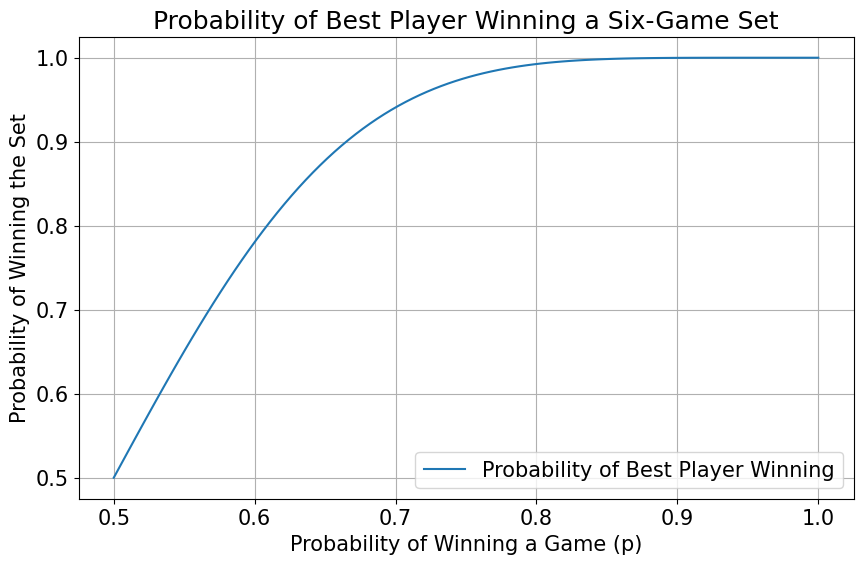

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function that calculates the probability of the best player winning
def six_game_set_prob(p_g):
    q_g = 1 - p_g

    # Calculate probabilities based on the table
    P6_0 = p_g**6 + q_g**6
    P6_1 = 6 * (p_g**6 * q_g + p_g * q_g**6)
    P6_2 = 21 * (p_g**6 * q_g**2 + p_g**2 * q_g**6)
    P6_3 = 56 * (p_g**6 * q_g**3 + p_g**3 * q_g**6)
    P6_4 = 126 * (p_g**6 * q_g**4 + p_g**4 * q_g**6)
    P7_5 = 252 * (p_g**7 * q_g**5 + p_g**5 * q_g**7)

    Pleft = p_g**6 + 6 * (p_g**6 * q_g) + 21 * (p_g**6 * q_g**2 ) + 56 * (p_g**6 * q_g**3 ) + 126 * (p_g**6 * q_g**4 ) + 252 * (p_g**7 * q_g**5 )

    # Total probability of Best player winning
    PB = Pleft / (P6_0 + P6_1 + P6_2 + P6_3 + P6_4 + P7_5)

    return PB

# Create an array of p values from 0 to 1
p_values = np.linspace(.5, 1, 100)

# Calculate the probability of the best player winning for each p value
probabilities = [six_game_set_prob(p) for p in p_values]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(p_values, probabilities, label='Probability of Best Player Winning')
plt.title('Probability of Best Player Winning a Six-Game Set')
plt.xlabel('Probability of Winning a Game (p)')
plt.ylabel('Probability of Winning the Set')
plt.grid(True)
plt.legend()
plt.show()


## Tennis 5 Set Matches Modelling


If we now define $p_s$ as the probability of the better player (B) to win a set and $q_s$ as the probability of worst player (W) to win a set, then the possible outcomes for a best-of-5 set match are:

<center>

| Winner | Loser | Probability of Outcome | Combinations | Example B Wins| Example W Wins
|--------|-------|------------------------|--------------|---------|------|
| 3 | 0 | $ p_s^3 + q_s^3 $ | 1 | BBB | WWW |
| 3 | 1 | $ 3(p_s^3q_s + p_sq_s^3) $ | $\binom{3}{1} = 3$ | BBWB,BWBB,WBBB | WWBW,WBWW,BWWW |
| 3 | 2 | $6(p_s^3q_s^2 + p_s^2q_s^3)$ | $\binom{4}{2} = 6$ | BBWWB, BWWBB, ... | WWBBW, WBBWW, ...|

</center>

\
The probability of the better player winning a match is the sum of the left column divided by the total probabilities:\
$$
P(B) = \frac{p_s^3 + 3p_s^3q_s + 6p_s^3q_s^2}{p_s^3 + q_s^3 +3(p_s^3q_s + p_sq_s^3) + 6(p_s^3q_s^2 + p_s^2q_s^3)}
$$
\
similarly the probability of the worse player winning the match is:\
\
$$
P(W) = \frac{q_s^3 + 3p_sq_s^3 + 6p_s^2q_s^3}{p_s^3 + q_s^3 +3(p_s^3q_s + p_sq_s^3) + 6(p_s^3q_s^2 + p_s^2q_s^3)}
$$

### Data Processing


In [ ]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})


data = new_data['loser_sets_won']
five_set_max = new_data[new_data['winner_sets_won'] == 3]

n = len(five_set_max)
print(n)

n0, n1, n2 = np.bincount(five_set_max['loser_sets_won'])
print('Winner\tLoser\tFrequency')
print('-------------------------')
print(f'3\t0\t{n0}')
print(f'3\t1\t{n1}')
print(f'3\t2\t{n2}')
print('-------------------------')
print(f'Total:\t\t{n0+n1+n2}')

print(five_set_max['winner_sets_won'].unique())
print(five_set_max['loser_sets_won'].unique())

43208
Winner	Loser	Frequency
-------------------------
3	0	23221
3	1	12665
3	2	7322
-------------------------
Total:		43208
[3]
[0 1 2]


### NLL Mosteller Model

In [ ]:
# Negative log-likelihood from outcome probabilities
# for 5 set matches ala Mosteller
def NLL_Mosteller(p, outcomes):

    n0, n1, n2 = np.bincount(outcomes)

    q = 1-p

    P0 = p**3 + q**3
    P1 = 3*((p**3)*q + p*(q**3))
    P2 = 6*((p**3)*(q**2) + (p**2)*(q**3))

    log_likelihood = n0*np.log(P0) + n1*np.log(P1) + n2*np.log(P2)

    return -log_likelihood

# initial (random) guess for p
p_init = .6

#check initial p makes sense
assert p_init > .5 and p_init < 1.

n0, n1, n2 = np.bincount(five_set_max['loser_sets_won'])

#p_analytic = 0.5
#print(f'Analytic min. p = {p_analytic:.5f}')

# minimize with scipy routines
# bounds is used to constrain optimizer to stay in regions where taking log(p) makes sense
epsilon = 1e-5
opt_results = scipy.optimize.minimize(lambda p: NLL_Mosteller(p, np.array(five_set_max['loser_sets_won'])),
                                      p_init,
                                      bounds=[(.5 + epsilon, 1. - epsilon)])

p_numeric = opt_results.x.squeeze()

print(f'Numeric min. p = {p_numeric:.4f}')

Numeric min. p = 0.8005


### 5 Set Probability Calculations

In [ ]:
def five_set_prob(p):

    q = 1 - p

    P0 = p**3 + q**3
    P1 = 3*((p**3)*q + p*(q**3))
    P2 = 6*((p**3)*(q**2) + (p**2)*(q**3))

    Pleft = p**3 + 3*(p**3)*q + 6*(p**3)*(q**2)
    Pright = q**3 + 3*p*(q**3) + 6*(p**2)*(q**3)

    PB = Pleft/(P0+P1+P2)
    PW = Pright/(P0+P1+P2)

    print(f'Best player probability of winning 5-set match:{PB:.4f}')
    print(f'Worst player probability of winning 5-set match:{PW:.4f}')

five_set_prob(0.8268)

Best player probability of winning 5-set match:0.9606
Worst player probability of winning 5-set match:0.0394


## Correlation Testing/Simulation

### Single Simulation of 10,000 matches
#### Fixed point probability
Here we run one simulation with 10,000 matches with the better player having a fixed probability of winning a point, p = 0.55.  Each match result gives us the number of sets won by the losing player.

In [ ]:
import random

def simulate_point(probability_player_a):
    return random.random() < probability_player_a

def simulate_game(probability_player_a):
    score_a = score_b = 0
    while abs(score_a - score_b) < 2 or (score_a < 4 and score_b < 4):
        if simulate_point(probability_player_a):
            score_a += 1
        else:
            score_b += 1
    return score_a, score_b

def simulate_set(probability_player_a):
    games_a = games_b = 0
    while games_a < 6 and games_b < 6:
        score_a, score_b = simulate_game(probability_player_a)
        if score_a > score_b:
            games_a += 1
        else:
            games_b += 1
    return games_a, games_b

def simulate_match(probability_player_a):
    sets_a = sets_b = 0
    while sets_a < 3 and sets_b < 3:
        games_a, games_b = simulate_set(probability_player_a)
        if games_a > games_b:
            sets_a += 1
        else:
            sets_b += 1
    return min(sets_a, sets_b)

# Example usage:
probability_player_a = 0.55  # Probability of player A winning a point
results = [simulate_match(probability_player_a) for _ in range(10000)]
sets_won_by_loser = np.array(results)
print(set(results))


{0, 1, 2}


From the resulting monte carlo simulation, we use the number of sets won by the losing player, and feed that into Mosteller once again to extract the probability of winning a match.

In [ ]:
# initial (random) guess for p
p_init = .6

#check initial p makes sense
assert p_init > .5 and p_init < 1.

n0, n1, n2 = np.bincount(sets_won_by_loser)

# minimize with scipy routines
# bounds is used to constrain optimizer to stay in regions where taking log(p) makes sense
epsilon = 1e-5
opt_results = scipy.optimize.minimize(lambda p: NLL_Mosteller(p, np.array(sets_won_by_loser)),
                                      p_init,
                                      bounds=[(.5 + epsilon, 1. - epsilon)])

p_numeric = opt_results.x.squeeze()

print(f'Numeric probability of winning a set p = {p_numeric:.4f}')

Numeric probability of winning a set p = 0.7997


Based on the simulated match results and the resulting probability to win a set, we compute the probability to win a 5-set match, for each of the pointp's (probability of winning a point).

In [ ]:
five_set_prob(.8046)

Best player probability of winning 5-set match:0.9456
Worst player probability of winning 5-set match:0.0544


### Six Simulations, varying point probability

Here we run 6 simulations by varying the probility of winning a point (pointp) from 0.5 to 0.65, each with 10,000 matches. For each set of results, we fit that into the Mostellar model to come up with a probability of winning a set.

In [ ]:
# Importing necessary libraries
import numpy as np

# Define the range of probabilities
probabilities = np.linspace(0.5, 0.65, num=6)  # From 0.5 to 1.0 with 6 values

# Initialize an empty list to store results for each probability
all_results = []
all_probabilities = []

# Iterate over each probability value
for probability_player_a in probabilities:
    # Simulate matches for the current probability
    results = [simulate_match(probability_player_a) for _ in range(10000)]
    # Store the results in the list
    all_results.append(results)

    sets_won_by_loser = np.array(results)
    # initial (random) guess for p
    p_init = .6

    #check initial p makes sense
    assert p_init > .5 and p_init < 1.

    n0, n1, n2 = np.bincount(sets_won_by_loser)

    # minimize with scipy routines
    # bounds is used to constrain optimizer to stay in regions where taking log(p) makes sense
    epsilon = 1e-5
    opt_results = scipy.optimize.minimize(lambda p: NLL_Mosteller(p, np.array(sets_won_by_loser)),
                                          p_init,
                                          bounds=[(.5 + epsilon, 1. - epsilon)])

    p_numeric = opt_results.x.squeeze()

    print(f'Numeric probability of winning a set p = {p_numeric:.4f} with prob of winning point = {probability_player_a:.4f}')
    all_probabilities.append([probability_player_a,p_numeric])


# Now all_results contains a list of lists, where each inner list contains results for a specific probability


Numeric probability of winning a set p = 0.5000 with prob of winning point = 0.5000
Numeric probability of winning a set p = 0.6909 with prob of winning point = 0.5300
Numeric probability of winning a set p = 0.8478 with prob of winning point = 0.5600
Numeric probability of winning a set p = 0.9350 with prob of winning point = 0.5900
Numeric probability of winning a set p = 0.9795 with prob of winning point = 0.6200
Numeric probability of winning a set p = 0.9944 with prob of winning point = 0.6500


Here we group all the probabilities (point, set, match) so we can plot them.


In [ ]:
all_probs = []
for probs in all_probabilities:
  pointp = probs[0]
  setp = probs[1]
  matchp = five_set_prob(setp)
  all_probs.append([pointp,setp,matchp])

Best player probability of winning 5-set match:0.5000
Worst player probability of winning 5-set match:0.5000
Best player probability of winning 5-set match:0.8247
Worst player probability of winning 5-set match:0.1753
Best player probability of winning 5-set match:0.9723
Worst player probability of winning 5-set match:0.0277
Best player probability of winning 5-set match:0.9975
Worst player probability of winning 5-set match:0.0025
Best player probability of winning 5-set match:0.9999
Worst player probability of winning 5-set match:0.0001
Best player probability of winning 5-set match:1.0000
Worst player probability of winning 5-set match:0.0000


#### Simulation Plotting

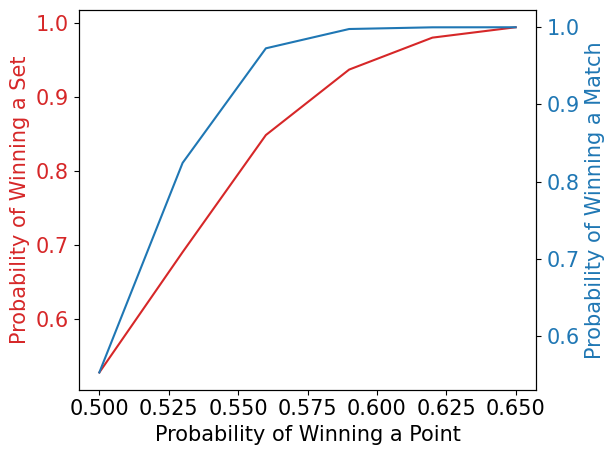

In [ ]:
import matplotlib.pyplot as plt

# Define the data as a list of lists
data = all_probs

# Extract x and y data
x_data = [point[0] for point in data]
y_set_data = [point[1] for point in data]
y_match_data = [point[2] for point in data]

# Create the plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Probability of Winning a Point')
ax1.set_ylabel('Probability of Winning a Set', color=color)
ax1.plot(x_data, y_set_data, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Probability of Winning a Match', color=color)
ax2.plot(x_data, y_match_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


We can see with a point probability of .55, the probability of winning a set is approx. .8 and of winning a match is over .9.  This agrees with our use of Mostellar with the historical data, which gave us a probability of winning a match as 0.9606, which roughly corresponds to pointp = .56 in our simulations.

# Misc. Code for Appendixes

# Tournament Predictions using ATP Rankings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from tabulate import tabulate


# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Initial rankings data from Mar 4, 2024
# Source: https://www.atptour.com/en/rankings/singles?RankRange=0-100&Region=all&DateWeek=Current%20Week
rankings = {
    "rank": [
        1, 2, 3, 4, 5,
        6, 7, 8, 9, 10,
        11, 12, 13, 14, 15,
        16, 17, 18, 19, 20,
        21, 22, 23, 24, 25,
        26, 27, 28, 29, 30,
        31, 32, 33, 34, 35,
        36, 37, 38, 39, 40,
        41, 42, 43, 44, 45,
        46, 47, 48, 49, 50,
        51, 52, 53, 54, 55,
        56, 57, 58, 59, 60,
        61, 62, 63, 64, 65,
        66, 67, 68, 69, 70,
        71, 72, 73, 74, 75,
        76, 77, 78, 79, 80,
        81, 82, 83, 84, 85,
        86, 87, 88, 89, 90,
        91, 92, 93, 94, 95,
        96, 97, 98, 99, 100,
        101, 102, 103, 104, 105,
        106, 107, 108, 109, 110,
        111, 112, 113, 114, 115,
        116, 117, 118, 119, 120,
        121, 122, 123, 124, 125,
        126, 127, 128
    ],
    "player": [
        "Novak Djokovic", "Carlos Alcaraz", "Jannik Sinner", "Daniil Medvedev", "Andrey Rublev",
        "Alexander Zverev", "Holger Rune", "Hubert Hurkacz", "Casper Ruud", "Alex de Minaur",
        "Stefanos Tsitsipas", "Taylor Fritz", "Grigor Dimitrov", "Ugo Humbert", "Karen Khachanov",
        "Ben Shelton", "Tommy Paul", "Frances Tiafoe", "Sebastian Baez", "Alexander Bublik",
        "Adrian Mannarino", "Francisco Cerundolo", "Alejandro Davidovich Fokina", "Nicolas Jarry", "Jan-Lennard Struff",
        "Lorenzo Musetti", "Tallon Griekspoor", "Cameron Norrie", "Sebastian Korda", "Tomas Martin Etcheverry",
        "Felix Auger-Aliassime", "Jiri Lehecka", "Jordan Thompson", "Christopher Eubanks", "Borna Coric",
        "Laslo Djere", "Jack Draper", "Sebastian Ofner", "Alejandro Tabilo", "Matteo Arnaldi",
        "Alexei Popyrin", "Roman Safiullin", "Arthur Fils", "Aslan Karatsev", "Daniel Evans",
        "Emil Ruusuvuori", "Miomir Kecmanovic", "Marcos Giron", "Dominik Koepfer", "Zhizhen Zhang",
        "Alexander Shevchenko", "Facundo Diaz Acosta", "Daniel Altmaier", "Gael Monfils", "Lorenzo Sonego",
        "Dusan Lajovic", "Yannick Hanfmann", "Fabian Marozsan", "Mariano Navone", "Nuno Borges",
        "Andy Murray", "Flavio Cobolli", "Tomas Machac", "Roberto Cabelles Baena", "Thiago Seyboth Wild",
        "Christopher O'Connell", "Pavel Kotov", "Mackenzie McDonald", "Aleksandar Vukic", "Stan Wawrinka",
        "Max Purcell", "Yoshihito Nishioka", "Luciano Darderi", "Marton Fucsovics", "Jaume Munar",
        "Taro Daniel", "Arthur Cazaux", "Rinky Hijikata", "Pedro Cachin", "Alex Michelsen",
        "Jakub Mensik", "Botic van de Zandschulp", "Arthur Rinderknech", "Daniel Elahi Galan", "Hugo Gaston",
        "Luca Van Assche", "Cristian Garin", "Alexandre Muller", "Pedro Martinez", "Federico Coria",
        "Dominic Thiem", "Aleksandar Kovacevic", "Brandon Nakashima", "J.J. Wolf", "Maximilian Marterer",
        "Jurij Rodionov", "Thiago Agustin Tirante", "Roberto Bautista Agut", "Thanasi Kokkinakis", "Constant Lestienne",
        "Sumit Nagal", "Albert Ramos-Vinolas", "Tomas Barrios Vera", "Quentin Halys", "Corentin Moutet",
        "Zsombor Piros", "James Duckworth", "Fabio Fognini", "Benoit Paire", "Juan Pablo Varillas",
        "Dominic Stricker", "David Goffin", "Thiago Monteiro", "Francisco Comesana", "Borna Gojo",
        "Vit Kopriva", "Diego Schwartzman", "Richard Gasquet", "Hamad Medjedovic", "Duje Ajdukovic",
        "Gregoire Barrere", "Zizou Bergs", "Luca Nardi", "Yosuke Watanuki", "Michael Mmoh",
        "Otto Virtanen", "Camilo Ugo Carabelli", "Liam Broady"
    ],
    "points": [
        9675, 8805, 8270, 7715, 5010,
        4950, 3720, 3405, 3405, 3210,
        3170, 3015, 2880, 2415, 2300,
        2145, 2120, 2115, 1985, 1984,
        1950, 1840, 1595, 1575, 1531,
        1480, 1445, 1380, 1345, 1335,
        1295, 1260, 1246, 1234, 1194,
        1190, 1151, 1116, 1116, 1091,
        1087, 1080, 1078, 1073, 1066,
        1041, 1030, 1015, 1008, 1006,
        1000, 963, 961, 937, 935,
        927, 920, 914, 906, 887,
        885, 880, 868, 831, 820,
        819, 819, 815, 801, 797,
        796, 788, 787, 782, 776,
        773, 769, 754, 754, 754,
        751, 750, 720, 709, 704,
        696, 690, 689, 687, 687,
        655, 654, 645, 640, 637,
        631, 616, 614, 609, 606,
        603, 588, 588, 580, 577,
        572, 569, 568, 565, 562,
        557, 553, 552, 552, 548,
        548, 538, 538, 532, 528,
        516, 513, 513, 512, 507,
        505, 494, 492
    ]
}

In [ ]:
def get_tourpts(tourtype):
    if tourtype == "gslam":
        return [10, 45, 90, 180, 360, 720, 1200, 2000]
    elif tourtype == "masters":
        return [10, 25, 45, 90, 180, 360, 600, 1000]
    elif tourtype == "atp500":
        return [10, 20, 45, 90, 180, 300, 500, 1000]
    elif tourtype == "atp250":
        return [10, 15, 25, 45, 90, 150, 250, 500]
    elif tourtype == "atp16": # for testing
        return [10, 15, 30, 60, 100]
    else:
        raise ValueError("Invalid tournament type. Valid options: gslam, masters, atp500, atp250, atp16")

# Example usage
tourtype = "gslam"
points = gen_tourpts(tourtype)
print(f"Points distribution for {tourtype}: {points}")


Points distribution for gslam: [10, 45, 90, 180, 360, 720, 1200, 2000]


In [ ]:
# With dict of players and point deltas, returns new rankings
def update_rankings(rankings, pointdeltas):
    # Update points for players in pointdeltas
    for player, delta in pointdeltas.items():
        if player in rankings["player"]:
            idx = rankings["player"].index(player)
            rankings["points"][idx] += delta
        else:
            # Add player dynamically if not found in the original rankings
            rankings["player"].append(player)
            rankings["points"].append(delta)

    # Sort rankings based on total points
    sorted_rankings = sorted(zip(rankings["player"], rankings["points"]), key=lambda x: x[1], reverse=True)
    sorted_players, sorted_points = zip(*sorted_rankings)

    # Update rankings dictionary with sorted data
    updated_rankings = {
        "rank": list(range(1, len(rankings["rank"]) + 1)),
        "player": list(sorted_players),
        "points": list(sorted_points)
    }

    return updated_rankings



In [ ]:
# genereates new pairwise probability matrix dataframe based on ranking points
def gen_prob(n, rankings):
    # Extract relevant data from the rankings dictionary
    players = rankings["player"][:n]
    points = rankings["points"][:n]

    # Create a DataFrame to store pairwise probabilities
    prob_matrix = pd.DataFrame(index=players, columns=players)

    # Calculate pairwise probabilities based on player points
    for i, player1 in enumerate(players):
        for j, player2 in enumerate(players):
            if i != j:
                prob_matrix.loc[player1, player2] = points[i] / (points[i] + points[j])

    # Fill diagonal with 0.5 (each player against themselves)
    prob_matrix.fillna(0.5, inplace=True)

    return prob_matrix

# Example usage
n = 16  # Number of players
pairwise_prob_df = gen_prob(n, rankings)
print(pairwise_prob_df)


                    Novak Djokovic  Carlos Alcaraz  Jannik Sinner  \
Novak Djokovic            0.500000        0.523539       0.539147   
Carlos Alcaraz            0.476461        0.500000       0.515666   
Jannik Sinner             0.460853        0.484334       0.500000   
Daniil Medvedev           0.443646        0.467010       0.482640   
Andrey Rublev             0.341164        0.362649       0.377259   
Alexander Zverev          0.338462        0.359869       0.374433   
Holger Rune               0.277716        0.297006       0.310259   
Hubert Hurkacz            0.260321        0.278870       0.291649   
Casper Ruud               0.260321        0.278870       0.291649   
Alex de Minaur            0.249127        0.267166       0.279617   
Stefanos Tsitsipas        0.246789        0.264718       0.277098   
Taylor Fritz              0.237589        0.255076       0.267169   
Grigor Dimitrov           0.229391        0.246470       0.258296   
Ugo Humbert               0.199752

In [ ]:
# For each round, add list of losers in order to calculate ranking points gained
# To be improved later
losers_per_round = []

# Simulates a tennis tournament comprised of list of players in rank order and with pairwise
# player probability matrix
def simulate_tournament(players, probm):

    if len(players) == 1:
        return players[0]  # Winner of the tournament

    # Pair players for the current round, ensuring highest rank plays with lowest, etc.
    matches = [(players[i], players[-(i + 1)]) for i in range(len(players) // 2)]

    # Simulate matches for this round
    winners = []
    losers = []
    for match in matches:
        player1, player2 = match
        # Get the probability of player1 winning against player2 from the probability matrix
        win_probability = probm.loc[player1, player2]
        if np.random.rand() < win_probability:
            winners.append(player1)
            losers.append(player2)
        else:
            winners.append(player2)
            losers.append(player1)
    losers_per_round.append(losers)
    # Recursively simulate the next round
    return simulate_tournament(winners, probm)




In [ ]:
# Based on list of losers per round, and a tournament winner, and a
# list of points to be added to each loser per round, generates
# a dictionary of players and points that should be added to their rankings.
def gen_point_deltas(losers, winner, points):
    # Initialize dictionary to store point deltas
    point_deltas = {}

    # Iterate through each list of losers and corresponding points
    for i, losers_list in enumerate(losers):
        for loser in losers_list:
            point_deltas[loser] = points[i]

    # Assign points to the winner
    point_deltas[winner] = points[-1]

    return point_deltas


In [ ]:
# Number of players per tournament
tournaments = {
    "French Open": 128,
    "Wimbledon": 128,
    "US Open": 128,
    "Australian Open": 128
}

# Initialize rankings, tournament_info
newrankings = rankings
tournament_info = []

#
# Run simulation for the next 4 Grand Slam tournaments, updating
# player ranks, pairwise probabilities, and draws after each
# simulated tournament
#
# Steps:
# gen probability matrix based on latests rankings
# gen draw, sorted in rank order
# reset losers_per_round = [] - to be improved later
# run simulation for draw with prob matrix
# calc point deltas for all players in tournament
# update rankings
# repeat
for tournament, n in tournaments.items():
    probm = gen_prob(n, newrankings)
    draw = newrankings['player'][:n]
    losers_per_round = []  # Each round of each tournament appends losers
    winner = simulate_tournament(draw, probm)
    points = get_tourpts('gslam')
    point_deltas = gen_point_deltas(losers_per_round, winner, points)
    newrankings = update_rankings(newrankings, point_deltas)

    # Append tournament information to list
    tournament_info.append([tournament, n, winner])

# Print tournament information in a table format
print(tabulate(tournament_info, headers=["Tournament", "Number of Players", "Winner"]))


Tournament         Number of Players  Winner
---------------  -------------------  --------------
French Open                      128  Carlos Alcaraz
Wimbledon                        128  Novak Djokovic
US Open                          128  Jannik Sinner
Australian Open                  128  Jannik Sinner


# Tournament Predictions using Mosteller

In [ ]:

def gen_mosteller_prob(rankings, p):
    n = len(rankings["player"])
    players = rankings["player"]
    ranks = rankings["rank"]

    # Create an empty DataFrame to store the pairwise probabilities
    prob_matrix = pd.DataFrame(index=players, columns=players)

    # Fill the DataFrame with pairwise probabilities
    for i in range(n):
        for j in range(n):
            if i == j:
                prob_matrix.iloc[i, j] = 0.5  # Diagonal entries
            else:
                # Determine the probability based on the ranks
                if ranks[i] < ranks[j]:
                    prob_matrix.iloc[i, j] = p
                else:
                    prob_matrix.iloc[i, j] = 1 - p

    return prob_matrix



In [ ]:
p_value = 0.93  # probability value of winning a match by better player in open era, from our previous Mosteller results
mosteller_prob_matrix = gen_mosteller_prob(rankings, p_value)
print(mosteller_prob_matrix)

                     Novak Djokovic Carlos Alcaraz Jannik Sinner  \
Novak Djokovic                  0.5           0.93          0.93   
Carlos Alcaraz                 0.07            0.5          0.93   
Jannik Sinner                  0.07           0.07           0.5   
Daniil Medvedev                0.07           0.07          0.07   
Andrey Rublev                  0.07           0.07          0.07   
...                             ...            ...           ...   
Yosuke Watanuki                0.07           0.07          0.07   
Michael Mmoh                   0.07           0.07          0.07   
Otto Virtanen                  0.07           0.07          0.07   
Camilo Ugo Carabelli           0.07           0.07          0.07   
Liam Broady                    0.07           0.07          0.07   

                     Daniil Medvedev Andrey Rublev Alexander Zverev  \
Novak Djokovic                  0.93          0.93             0.93   
Carlos Alcaraz                  0.93     

In [ ]:
# Simulate uising Mosteller
# Number of players per tournament
tournaments = {
    "French Open": 128,
    "Wimbledon": 128,
    "US Open": 128,
    "Australian Open": 128
}

# Initialize rankings, tournament_info
newrankings = rankings
tournament_info = []

#
# Run simulation for the next 4 Grand Slam tournaments, updating
# player ranks, pairwise probabilities, and draws after each
# simulated tournament
#
# Steps:
# gen probability matrix based on latests rankings
# gen draw, sorted in rank order
# reset losers_per_round = [] - to be improved later
# run simulation for draw with prob matrix
# calc point deltas for all players in tournament
# update rankings
# repeat
for tournament, n in tournaments.items():
    probm = mosteller_prob_matrix # Static probability matrix since from Mosteller
    draw = newrankings['player'][:n]
    losers_per_round = []  # Each round of each tournament appends losers
    winner = simulate_tournament(draw, probm)
    points = get_tourpts('gslam')
    point_deltas = gen_point_deltas(losers_per_round, winner, points)
    newrankings = update_rankings(newrankings, point_deltas)

    # Append tournament information to list
    tournament_info.append([tournament, n, winner])

# Print tournament information in a table format
print(tabulate(tournament_info, headers=["Tournament", "Number of Players", "Winner"]))


Tournament         Number of Players  Winner
---------------  -------------------  --------------
French Open                      128  Andrey Rublev
Wimbledon                        128  Carlos Alcaraz
US Open                          128  Jannik Sinner
Australian Open                  128  Novak Djokovic
